# Command Hammer

A Command and Colours derivative for Warhammer Fantasy

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
sns.set_theme()

## Simulate    

In [3]:
def hit_roll(attacks, attacker_ws, defender_ws, samples=100000):
    target = min(max(2, 7 - (attacker_ws - defender_ws)), 12)
    rolls = stats.randint(1, 7).rvs((samples, 2)).sum(axis=1)
    successes = np.where((rolls >= target) & (rolls > 2), rolls - target + 1, 0)
    bounded = np.where(successes >= attacks, attacks, successes)
    return bounded

In [4]:
def wound_roll(hits, attacker_s, defender_t):
    target = min(max(2, 7 - (attacker_s - defender_t)), 12)
    rolls = stats.randint(1, 7).rvs((hits.size, 2)).sum(axis=1)
    successes = np.where((hits != 0) & (rolls >= target) & (rolls > 2), rolls - target + 1, 0)
    damage = np.where(successes >= hits, hits, successes)
    retreats = np.where(successes > hits, successes - hits, 0)
    return np.concatenate([damage.reshape(-1, 1), retreats.reshape(-1, 1)], axis=1)

In [5]:
def adjusted_break(breaks, defender_ld):
    damage = breaks[:, 0]
    base = breaks[:, 1]
    if defender_ld >= 0:
        retreats = np.where(base > defender_ld, base - defender_ld, 0)
    else:
        abs_ld = (- defender_ld)
        retreats = np.where(damage > abs_ld, base + abs_ld, base + damage)
    return np.concatenate([damage.reshape(-1, 1), retreats.reshape(-1, 1)], axis=1)

In [6]:
def combat_resolution(attacks, attacker_ws, defender_ws, attacker_s, defender_t, defender_ld, samples=10000):
    return adjusted_break(wound_roll(hit_roll(attacks, attacker_ws, defender_ws, samples=samples), 
                                     attacker_s, defender_t), 
                          defender_ld)

In [7]:
def combat_stats(resolution):
    df = (pd.DataFrame(resolution, columns=["damage", "retreats"])
          .assign(freq=1)
          .groupby(["damage", "retreats"])
          .count()
          .assign(prob=lambda df: df["freq"]/df["freq"].sum())
          .reset_index()
          .sort_values("prob", ascending=False))
    return df

In [8]:
def combat_expectation(resolution):
    return resolution.mean(axis=0)

In [9]:
acc = []
for ws_delta in range(-5, 6):
    for st_delta in range(-5, 6):
        resolution = combat_resolution(4, ws_delta, 0, st_delta, 0, 0)
        expectation = combat_expectation(resolution)
        acc.append((ws_delta, st_delta, expectation[0], expectation[1]))

data = pd.DataFrame(acc, columns=["ws_delta", "st_delta", "damage", "retreats"])
damage_table = (data.pivot_table(index="st_delta", columns="ws_delta", values="damage")
                .sort_index(ascending=False))
retreats_table = (data.pivot_table(index="st_delta", columns="ws_delta", values="retreats")
                  .sort_index(ascending=False))

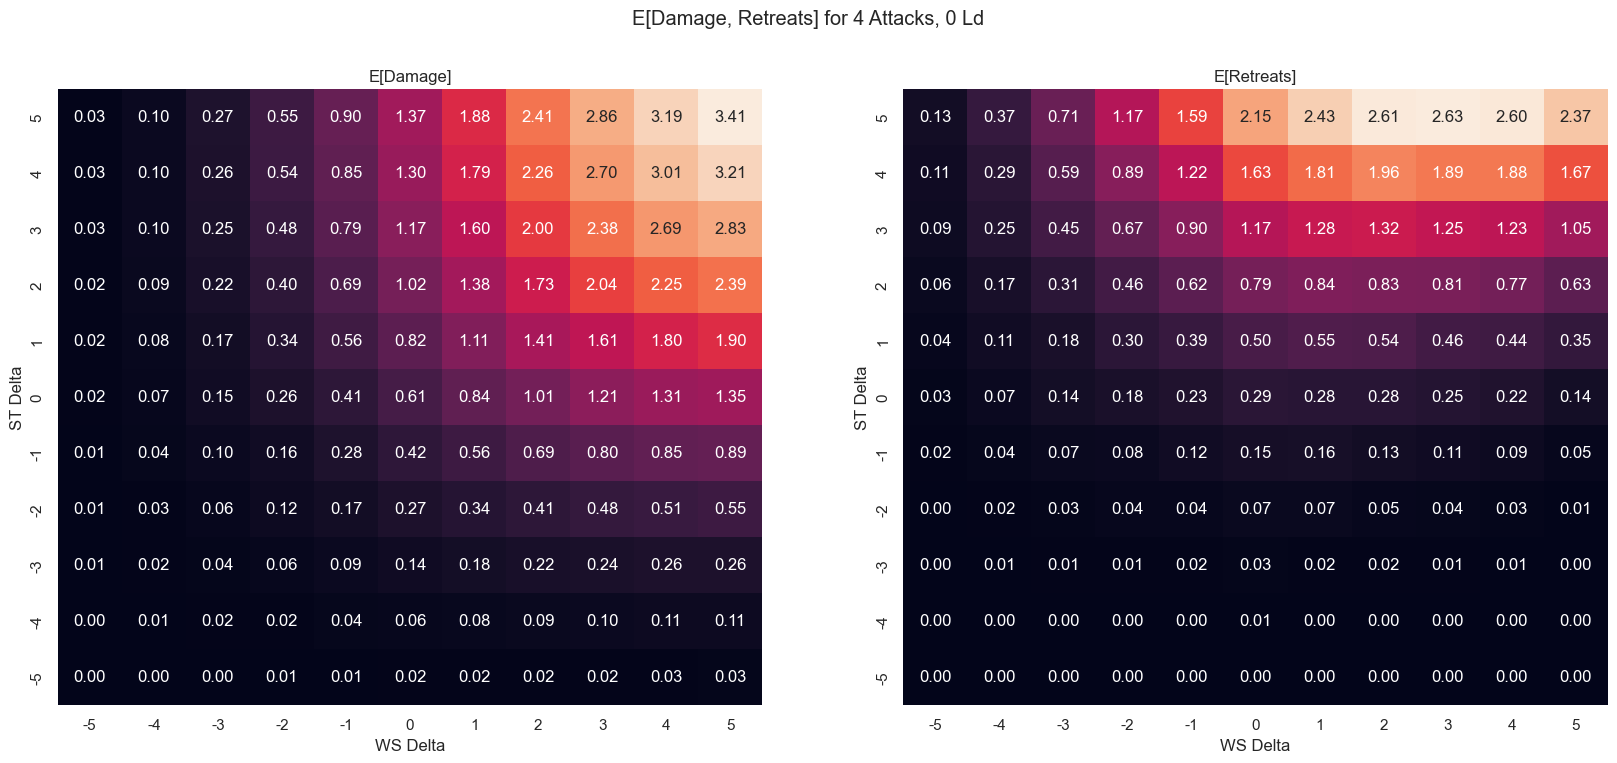

In [10]:
f, axs = plt.subplots(1, 2)
f.set_size_inches(20, 8)
sns.heatmap(damage_table, ax=axs[0], annot=True, fmt=".2f", cbar=False)
sns.heatmap(retreats_table, ax=axs[1], annot=True, fmt=".2f", cbar=False)
axs[0].set_xlabel("WS Delta")
axs[0].set_ylabel("ST Delta")
axs[1].set_xlabel("WS Delta")
axs[1].set_ylabel("ST Delta")
axs[0].set_title("E[Damage]")
axs[1].set_title("E[Retreats]")
f.suptitle("E[Damage, Retreats] for 4 Attacks, 0 Ld");